# Depedency code

In [1]:
%run ../lib/cmdbench/bioinformatics/multibench.py

In [2]:
import os

os.environ['BIGSI_CONFIG'] = 'berkleydb.yaml'

# Software versions

In [3]:
!mccortex 31 2>&1 | grep version

version: mccortex=v0.0.3-610-g400c0e3 zlib=1.2.11 htslib=1.8-17-g699ed53 ASSERTS=ON hash=Lookup3 CHECKS=ON k=3..31


In [4]:
!bigsi --version | grep bigsi-v

bigsi-v0.3.1


# Benchmarking

In [5]:
import sys
import os
import shutil
import numpy as np
import glob
import cmdbench

def clean_if_exists(path):
    if os.path.exists(path):
        if(os.path.isfile(path)):
            os.remove(path)
        else:
            shutil.rmtree(path)
            os.mkdir(path)
            
def get_last_n_lines(string, n):
    return "\n".join(string.split("\n")[-n:])
    
def benchmark_list_to_results(benchmark_firsts_list):
    return {
        "memory": max(list(map(lambda result: result.memory.max, benchmark_firsts_list))),
        "disk_read": max(list(map(lambda result: result.disk.read_chars, benchmark_firsts_list))),
        "disk_write": max(list(map(lambda result: result.disk.write_chars, benchmark_firsts_list))),
        "runtime": sum(list(map(lambda result: result.process.execution_time, benchmark_firsts_list)))
    }

def sampling_func(input_size):
    return input_samples[:input_size]

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

input_dir = 'input'

input_files_1 = [os.path.basename(f) for f in glob.glob(f'{input_dir}/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
print(input_samples)

['MOD1_LS1005', 'CFSAN000961', 'CFSAN001112', 'CFSAN023467', 'CFSAN001115', 'CFSAN000970', 'MOD1_LS982', 'CFSAN000958', 'D7331', 'CFSAN000960', '2014D-0189', '2014C-3656', 'CFSAN001140', 'MOD1_LS1006', 'CFSAN023470', 'CFSAN023466', 'CFSAN000951', 'D7321', 'MOD1_LS997', 'CFSAN023464', '2014C-3907', 'PNUSA000195', 'CFSAN000752', 'CFSAN023469', 'CFSAN000661', 'CFSAN000191', 'PNUSAL000730', 'CFSAN000212', 'PNUSA000196', 'CFSAN023471', 'CFSAN000669', 'D7323', '2014D-0070', 'MOD1_LS1008', '2014D-0068', 'CFSAN023468', 'D7333', 'D7320', '2014C-3850', 'CFSAN000700', 'D7327', 'D7330', 'D5663', 'CFSAN023465', 'CFSAN000952', '2014C-3857', 'MOD1_LS1000', 'MOD1_LS995', 'CFSAN000189', 'MOD1_LS998', 'CFSAN000954', 'D7329', '2014C-3655', 'MOD1_LS996', 'D7316', 'CFSAN002349', 'MOD1_LS1004', 'MOD1_LS1010', 'MOD1_LS985', '2014D-0067', 'D7322', 'CFSAN000963', 'D7324', 'CFSAN023463', '2014C-3600', '2014C-3599', 'CFSAN000753', 'D7328', 'PNUSAL000870', 'MOD1_LS1011', 'CFSAN000968', 'PNUSAL000957', 'CFSAN00021

In [6]:
nproc=4
kmer=31

bigsi_dir = 'bigsi-data'
sample_sizes = [1,10,20,30,40,50,60,70,80,85]

def reset_func():
    # Delete indexed data
    os.system("bigsi delete")

    # Delete all saved bigsi data
    clean_if_exists(bigsi_dir)
    clean_if_exists("test-berkeley.db")

mccortex_command = {
    "command": f"mccortex 31 build --nkmers 100000000 --threads 1 --kmer {kmer} --mem 20G" \
        + f" --sample % --seq2 {input_dir}/%_1.fastq.gz:{input_dir}/%_2.fastq.gz {bigsi_dir}/%.ctx",
    "parallel_args": f"-j {nproc} -I%"
}

bigsi_bloom_command = {
    "command": f"bigsi bloom -c berkleydb.yaml {bigsi_dir}/%.ctx {bigsi_dir}/%.bloom",
    "parallel_args": f"-j {nproc} -I%"
}

bigsi_build_command = {
    "command": lambda sample_files: "bigsi build -c berkleydb.yaml" + " -s " + (" -s ").join(sample_files) \
        + " " + " ".join(list(map(lambda sample_file: f"{bigsi_dir}/%s.bloom" % sample_file, sample_files))),
}

query_repeat_count = 2
query_sequence = "GAAGAAGATGGTGTACGCGGTGCGCGCCGCTATCTCGACCACCTTAAAATGGAATATGCCTTCTGGATGGACG"

query_command = {
    "command": "bigsi search % --config berkleydb.yaml -t 0.8",
    "parallel_argfiles": [query_sequence] * query_repeat_count,
    "parallel_args": "-j 1 -I%"
}

multibench_results, debug_str = multi_cmdbench({
"index": [mccortex_command, bigsi_bloom_command, bigsi_build_command],
"query": [query_command]
}, reset_func = reset_func, iterations = 1, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results=benchmark_list_to_results, active_output_print = True)

>>>>>>>>>>>>>
parallel -j 4 -I% mccortex 31 build --nkmers 100000000 --threads 1 --kmer 31 --mem 20G --sample % --seq2 input/%_1.fastq.gz:input/%_2.fastq.gz bigsi-data/%.ctx ::: MOD1_LS1005

STDOUT: 
-------------
STDERR: [18 Jul 2020 19:35:44-LuR][cmd] /home/CSCScience.ca/apetkau/miniconda3/envs/cmdbench/bin/mccortex31 build --nkmers 100000000 --threads 1 --kmer 31 --mem 20G --sample MOD1_LS1005 --seq2 input/MOD1_LS1005_1.fastq.gz:input/MOD1_LS1005_2.fastq.gz bigsi-data/MOD1_LS1005.ctx
[18 Jul 2020 19:35:44-LuR][cwd] /home/CSCScience.ca/apetkau/workspace/thesis-benchmarking/bigsi
[18 Jul 2020 19:35:44-LuR][version] mccortex=v0.0.3-610-g400c0e3 zlib=1.2.11 htslib=1.8-17-g699ed53 ASSERTS=ON hash=Lookup3 CHECKS=ON k=3..31
[18 Jul 2020 19:35:44-LuR] Saving graph to: bigsi-data/MOD1_LS1005.ctx
[18 Jul 2020 19:35:44-LuR][sample] 0: MOD1_LS1005
[18 Jul 2020 19:35:44-LuR][task] input/MOD1_LS1005_1.fastq.gz; FASTQ offset: auto-detect, threshold: off; cut homopolymers: off; remove PCR duplicate

# Save and reload results

In [7]:
save_path = "bigsi-results.txt"

samples_per_sample_size = []
for sample_size in sample_sizes:
        samples_per_sample_size.append(input_samples[:sample_size])

save_multibench_results(multibench_results, samples_per_sample_size, save_path)

In [8]:
multibench_results, samples_per_sample_size = read_multibench_results(save_path)
print(samples_per_sample_size)

[['MOD1_LS1005'], ['MOD1_LS1005,', 'CFSAN000961,', 'CFSAN001112,', 'CFSAN023467,', 'CFSAN001115,', 'CFSAN000970,', 'MOD1_LS982,', 'CFSAN000958,', 'D7331,', 'CFSAN000960'], ['MOD1_LS1005,', 'CFSAN000961,', 'CFSAN001112,', 'CFSAN023467,', 'CFSAN001115,', 'CFSAN000970,', 'MOD1_LS982,', 'CFSAN000958,', 'D7331,', 'CFSAN000960,', '2014D-0189,', '2014C-3656,', 'CFSAN001140,', 'MOD1_LS1006,', 'CFSAN023470,', 'CFSAN023466,', 'CFSAN000951,', 'D7321,', 'MOD1_LS997,', 'CFSAN023464'], ['MOD1_LS1005,', 'CFSAN000961,', 'CFSAN001112,', 'CFSAN023467,', 'CFSAN001115,', 'CFSAN000970,', 'MOD1_LS982,', 'CFSAN000958,', 'D7331,', 'CFSAN000960,', '2014D-0189,', '2014C-3656,', 'CFSAN001140,', 'MOD1_LS1006,', 'CFSAN023470,', 'CFSAN023466,', 'CFSAN000951,', 'D7321,', 'MOD1_LS997,', 'CFSAN023464,', '2014C-3907,', 'PNUSA000195,', 'CFSAN000752,', 'CFSAN023469,', 'CFSAN000661,', 'CFSAN000191,', 'PNUSAL000730,', 'CFSAN000212,', 'PNUSA000196,', 'CFSAN023471'], ['MOD1_LS1005,', 'CFSAN000961,', 'CFSAN001112,', 'CFSAN023

# Plot

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5

[{'runtime': 1183.2, 'memory': 2788917248.0, 'disk_read': 153145037827.0, 'disk_write': 153217248137.0}, {'runtime': 1911.88, 'memory': 8584237056.0, 'disk_read': 2860331607.0, 'disk_write': 2775906000.0}, {'runtime': 4147.99, 'memory': 9047957504.0, 'disk_read': 5958496657.0, 'disk_write': 5791009518.0}, {'runtime': 5106.07, 'memory': 11903606784.0, 'disk_read': 8221118422.0, 'disk_write': 7968949465.0}, {'runtime': 7895.27, 'memory': 12780646400.0, 'disk_read': 11776165249.0, 'disk_write': 11441520915.0}, {'runtime': 10015.09, 'memory': 20931813376.0, 'disk_read': 16298975135.0, 'disk_write': 15881779279.0}, {'runtime': 11717.09, 'memory': 20285235200.0, 'disk_read': 19167041136.0, 'disk_write': 18666194424.0}, {'runtime': 13853.86, 'memory': 20705603584.0, 'disk_read': 22659368847.0, 'disk_write': 22076322190.0}, {'runtime': 15532.32, 'memory': 20450836480.0, 'disk_read': 25687776782.0, 'disk_write': 25020335711.0}, {'runtime': 17907.12, 'memory': 20984872960.0, 'disk_read': 2848662

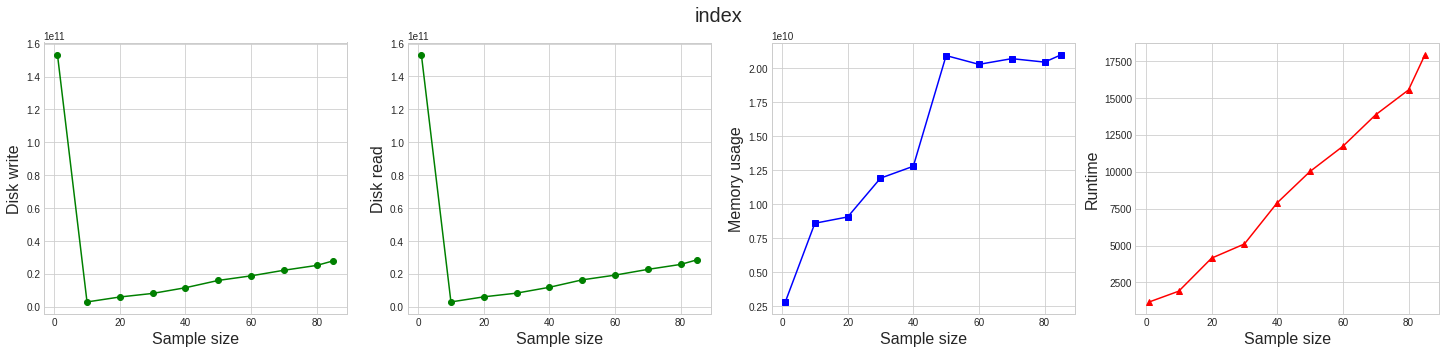

In [10]:
# Indexing Plots
plot_resources(multibench_results, sample_sizes, "index")

[{'runtime': 1.47, 'memory': 265650176.0, 'disk_read': 20437892.0, 'disk_write': 932501.0}, {'runtime': 1.11, 'memory': 83243008.0, 'disk_read': 19318095.0, 'disk_write': 909740.0}, {'runtime': 1.34, 'memory': 83820544.0, 'disk_read': 19319307.0, 'disk_write': 926211.0}, {'runtime': 1.28, 'memory': 83496960.0, 'disk_read': 19318142.0, 'disk_write': 926135.0}, {'runtime': 1.25, 'memory': 83636224.0, 'disk_read': 19318167.0, 'disk_write': 926139.0}, {'runtime': 2.03, 'memory': 83660800.0, 'disk_read': 19329915.0, 'disk_write': 927063.0}, {'runtime': 1.25, 'memory': 83365888.0, 'disk_read': 19323201.0, 'disk_write': 918299.0}, {'runtime': 1.19, 'memory': 83562496.0, 'disk_read': 19321858.0, 'disk_write': 910007.0}, {'runtime': 1.28, 'memory': 83181568.0, 'disk_read': 19321985.0, 'disk_write': 926403.0}, {'runtime': 1.26, 'memory': 83476480.0, 'disk_read': 19316983.0, 'disk_write': 917857.0}]


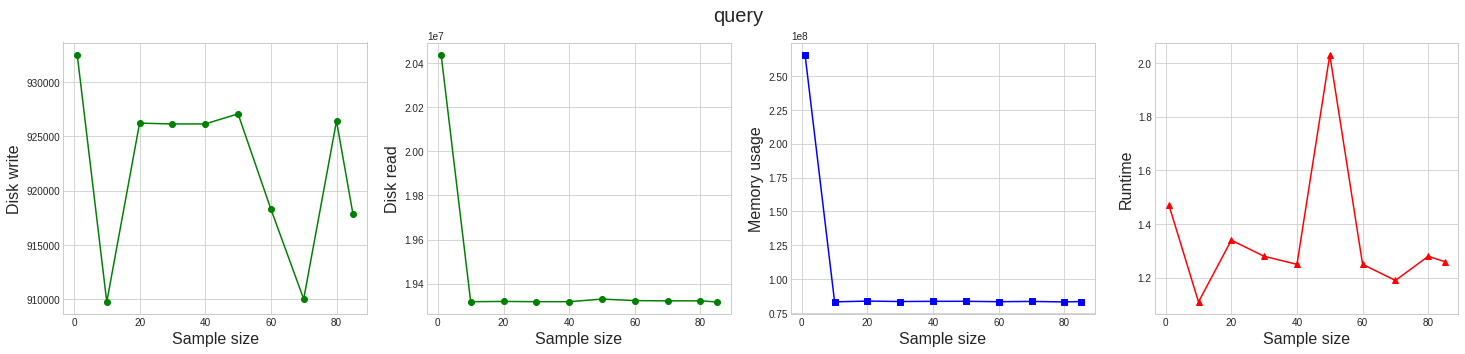

In [11]:
# Querying Plots
plot_resources(multibench_results, sample_sizes, "query")